# Copyright Netherlands eScience Center <br>
** Function     : Predict the Spatial Sea Ice Concentration with ConvLSTM at weekly time scale** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.05.21 ** <br>
** Last Update  : 2019.05.21 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib <br>
Description     : This notebook serves to predict the Arctic sea ice using deep learning. We also include many climate index (to represent the forcing from atmosphere). The convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>

Return Values   : Time series and figures <br>

Here is the information of climate index in details:<br>
**NAO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml <br>
**ENSO - NINO 3.4 SST** @ 1950 Jan - 2018 Jan (817 records) <br>
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/ <br>
**AO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao.shtml <br>
**AMO** @ 1950 Jan - 2018 Feb (818 records) <br>
AMO unsmoothed, detrended from the Kaplan SST V2. The result is standarised.<br>
https://www.esrl.noaa.gov/psd/data/timeseries/AMO/<br>

(All the NOAA index shown above are given by NCEP/NCAR Reanalysis (CDAS))<br>

**PDO** @ 1900 Jan - 2018 Feb (1418 records)<br>
This PDO index comes from University of Washington, it contains SST data from the following 3 datasets:<br>
- UKMO Historical SST data set for 1900-81;
- Reynold's Optimally Interpolated SST (V1) for January 1982-Dec 2001)
- OI SST Version 2 (V2) beginning January 2002 -<br>

http://research.jisao.washington.edu/pdo/PDO.latest<br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

The method comes from the study by Shi et. al. (2015) Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting. <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/Scripts/DeepClim")
# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
import deepclim.deepArray_CPU
#import deepclim.function

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################   path  ######################################
# please specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Maps'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
    dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
                                 'siv_monthly_PIOMASS_1979_2017.nc'))
    # OHC interpolated on ERA-Interim grid
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                'ohc_monthly_oras2erai_1978_2017.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                            'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    # ********************************** data gallery *************************************** #
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim)
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    #SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    #SIV (PIOMASS)
    SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / from 90 N upto 40 N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:-1,:,:67,:]/1000 # unit Peta Joule
    latitude_ORAS4 = dataset_ORAS4_OHC.variables['latitude'][:]
    longitude_ORAS4 = dataset_ORAS4_OHC.variables['longitude'][:]
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
    NAO = dataset_index.variables['NAO'][348:-1]
    NINO = dataset_index.variables['NINO'][348:-1]
    AMO = dataset_index.variables['AMO'][348:-1]
    PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [5]:
    # *************************   regionalization sea mask   ***************************** #
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [6]:
    # *************************  temporal interpolation matrix  ***************************** #
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= deepclim.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [ ]:
    # *************************  temporal interpolation single series  ***************************** #

In [7]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = deepclim.preprocess.operator.unfold(SIC_ERAI_area)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [8]:
    print ('******************  choose the fields from target region  *******************')
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,18:26,212:228]
    ohc_exp = OHC_300_ORAS4_weekly_series[:,18:26,212:228]
    print(sic_exp.shape)
    print(ohc_exp.shape)
    print(latitude_ERAI[18:26])
    print(longitude_ERAI[212:228])
    print(latitude_ORAS4[18:26])
    print(longitude_ORAS4[212:228])
    #print(latitude_ERAI[26:40])
    #print(longitude_ERAI[180:216])

******************  choose the fields from target region  *******************
(1824, 8, 16)
(1824, 8, 16)
[76.   75.25 74.5  73.75 73.   72.25 71.5  70.75]
[-21.   -20.25 -19.5  -18.75 -18.   -17.25 -16.5  -15.75 -15.   -14.25
 -13.5  -12.75 -12.   -11.25 -10.5   -9.75]
[76.   75.25 74.5  73.75 73.   72.25 71.5  70.75]
[-21.   -20.25 -19.5  -18.75 -18.   -17.25 -16.5  -15.75 -15.   -14.25
 -13.5  -12.75 -12.   -11.25 -10.5   -9.75]


In [9]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = deepclim.preprocess.operator.normalize(sic_exp)
    ohc_exp_norm = deepclim.preprocess.operator.normalize(ohc_exp)
    print ('====================    A series of time (index)    ====================')
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year))
    month_cycle.astype(float)
    month_2D = np.repeat(month_cycle[:,np.newaxis],8,1)
    month_exp = np.repeat(month_2D[:,:,np.newaxis],16,2)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
#     seansonal_cycle_SIC = np.zeros(48,dtype=float)
#     for i in np.arange(48):
#         seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::48],axis=0)
    # weight for loss
#     weight_month = np.array([0,1,1,
#                              1,0,0,
#                              1,1,1,
#                              0,0,0])
    #weight_loss = np.repeat(weight_month,4)
    #weight_loss = np.tile(weight_loss,len(year))

*******************  pre-processing  *********************
=========================   normalize data   ===========================
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


(1824, 8, 16)
[[ 781.58258609  781.58258609  782.66349954  790.13489657  797.89642001
   803.78367546  805.84280275  807.9686848   812.38476826  810.23321132
   809.79930544  809.42188435  798.4587004   782.23729614  765.83616755
   710.06257388]
 [   0.            0.            0.          821.14595088  823.39406679
   832.4162531   838.34187591  844.25128635  841.4384394   837.35292108
   834.20231633  828.34424508  810.55386633  784.94101697  758.95122991
   708.12813849]
 [   0.          859.25783231  856.95202496  860.84041595  871.40799059
   881.92735032  872.1510675   863.99707472  856.174914    840.36325844
   827.35374022  815.73394599  782.81592263  744.96437911  709.69800583
   656.88849434]
 [ 911.09730046  913.57410904  913.62459554  916.5349941   920.47888114
   908.74225346  895.10792713  876.12797079  839.20600126  815.44913053
   796.55975292  749.87309923  695.85847773  620.62764466  546.41990578
   473.27683821]
 [ 975.54516922  960.95529277  958.61880256  956.23887

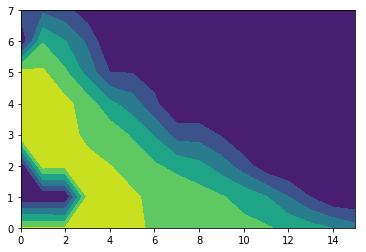

In [10]:
    print(sic_exp.shape)
    ax = plt.contourf(sic_exp[43,:,:])
    print(sic_exp[443,:,:])
    print(month_exp[0,:,:].shape)

In [11]:
    x_input = np.stack((sic_exp_norm[1,:,:],
                        ohc_exp_norm[1,:,:],
                        month_exp[1,:,:]))
    print(x_input[1,:,:])
    print(x_input[:].shape)

[[0.41740086 0.41740086 0.41740086 0.29478703 0.29478703 0.30507784
  0.30507784 0.30507784 0.32231528 0.32231528 0.32125206 0.32125206
  0.32125206 0.35242658 0.35242658 0.35242658]
 [0.41740086 0.41740086 0.28888892 0.28888892 0.28888892 0.27662535
  0.27662535 0.30989961 0.30989961 0.30989961 0.33252725 0.33252725
  0.34004502 0.34004502 0.34004502 0.32814691]
 [0.41740086 0.41740086 0.25726003 0.25726003 0.25726003 0.27418236
  0.27418236 0.30288126 0.30288126 0.32102812 0.32102812 0.32102812
  0.30673947 0.30673947 0.28873148 0.28873148]
 [0.2402761  0.2402761  0.25569137 0.25569137 0.28184371 0.28184371
  0.27633132 0.29563    0.29563    0.30169902 0.30169902 0.29435956
  0.29435956 0.29435956 0.28807627 0.28807627]
 [0.2259177  0.2259177  0.25667392 0.25667392 0.28720271 0.28720271
  0.30418527 0.30418527 0.30418527 0.29887142 0.29887142 0.2965886
  0.2965886  0.31770928 0.30146529 0.32350897]
 [0.23207001 0.23207001 0.26739577 0.26739577 0.28983059 0.28983059
  0.29688334 0.296

# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [10]:
    print ('*******************          prepare input tensor for LSTM           *********************')
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    hidden_channels = [3, 3, 2] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    kernel_size = 3
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    num_layers = 1
    learning_rate = 0.01
    num_epochs = 1
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # standard LSTM input dimension
    # [sequence_length(time step), batch_size, input_size]
    # example : x = torch.autograd.Variable(torch.randn(6, 3, 5))
    # prepare input array for LSTM input -> dimension
    # take 3 year as test data
    test_year = 3

*******************          prepare input tensor for LSTM           *********************
*******************  create basic dimensions for tensor and network  *********************
1.0.1.post2
Is CUDA available? False


In [11]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    #print(SIC_ERAI_sum_norm[:-test_year*12])
    #print(x_input.shape)
    #print(x_input[:,:,:])
    sequence_len, _, _ = sic_exp_norm.shape
    print(sequence_len)

*******************  preview of input tensor  *********************
1824


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [ ]:
    %%time
    print ('*******************  run LSTM  *********************')
    # check the sequence length
    sequence_len, height, width = sic_exp_norm.shape

    # initialize our model
    model = deepclim.deepArray_CPU.ConvLSTM(input_channels, hidden_channels, kernel_size).cuda()
    loss_fn = torch.nn.MSELoss(size_average=True)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        
        for timestep in range(sequence_len - test_year*12*4):
            # hidden state re-initialized inside the model when timestep=0
            #print ('**********   create input tensor with multi-input dimension   ************')
            # create variables
            x_input = np.stack((sic_exp_norm[timestep,:,:],
                                ohc_exp_norm[timestep,:,:],
                                month_exp[timestep,:,:])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).cuda()
            #print ('*******************   create training tensor with multi-input dimension  *********************')
            y_train_stack = np.stack((sic_exp_norm[timestep+1,:,:],
                                      ohc_exp_norm[timestep+1,:,:],)) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).cuda()
            #print ('*******************   create tensors and variables  *********************')   
            # Forward pass
            y_pred, _ = model(x_var, timestep)
            # choose training data
            y_train = y_var        
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss = loss_fn(y_pred, y_train)
            else:
                loss = loss_fn(y_pred, y_train) + loss
            #print (timestep)
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 2 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            #print(y_pred)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    torch.save(model, os.path.join(output_path,'convlstm.pkl')) # save lstm model

In [10]:
    %%time
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    # time series before test data
    pred_base_sic = sic_exp_norm[:-test_year*12*4,:,:]
    pred_base_ohc = ohc_exp_norm[:-test_year*12*4,:,:]
    # prediction validation with training data
    pred_fake_sic = sic_exp_norm[0,:,:].reshape(-1,height,width)
    pred_fake_ohc = ohc_exp_norm[0,:,:].reshape(-1,height,width)
    
    for i in np.arange(1,sequence_len,1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        #model.hidden = model.init_hidden()
        # based on the design of this module, the hidden states and cell states are initialized when the module is called.
        #############################################################################
        ###############           before time of prediction           ###############
        #############################################################################
        if i <= (sequence_len-test_year*12*4):
            # create variables
            x_input = np.stack((sic_exp_norm[i-1,:,:],
                                ohc_exp_norm[i-1,:,:],
                                month_exp[i-1,:,:])) #vstack,hstack,dstack
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).cuda()
            # make prediction
            last_pred, _ = model(x_var_pred, i-1)
            # save the predicted data for validation (GPU data should be transferred to CPU)
            pred_fake_sic = np.vstack((pred_fake_sic[:,:,:],y_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)))
            pred_fake_ohc = np.vstack((pred_fake_ohc[:,:,:],y_pred[0,1,:,:].cpu().data.numpy().reshape(-1,height,width)))
            # record the real prediction after the time of prediction
            if i == (sequence_len-test_year*12*4):
                # GPU data should be transferred to CPU
                data_predict_sic = y_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)
                data_predict_ohc = y_pred[0,1,:,:].cpu().data.numpy().reshape(-1,height,width)
        #############################################################################
        ###############            after time of prediction           ###############
        #############################################################################
        else:
            # prepare predictor
            # use the predicted data to make new prediction
            x_input = np.stack((data_predict_sic[i-(sequence_len-test_year*12*4+1),:,:],
                                data_predict_ohc[i-(sequence_len-test_year*12*4+1),:,:],
                                month_exp[i-1,:,:])) #vstack,hstack,dstack
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                 requires_grad=False).cuda()        
            # make prediction
            last_pred, _ = model(x_var_pred, i)
            # record the prediction
            data_predict_sic = np.vstack((data_predict_sic[:,:,:],y_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)))
            data_predict_ohc = np.vstack((data_predict_ohc[:,:,:],y_pred[0,0,:,:].cpu().data.numpy().reshape(-1,height,width)))

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 3 years of total time series are treated as test data  ************


In [16]:
    for i in range(3):
        print(i)

0
1
2


In [12]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt((x-y)**2)
    
        return rmse

    # calculate the RMSE error of predictied years
    error_pred = np.sum(RMSE(data_predict[-test_year*12*4:,0],SIC_ERAI_sum_norm[-test_year*12*4:]))
    print ("RMSE = {}".format(error_pred))

*******************  evaluation matrix  *********************
RMSE = 1.9769703856266507


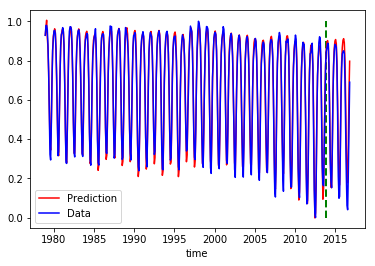

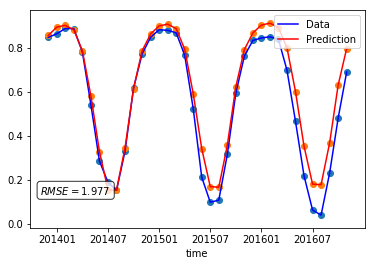

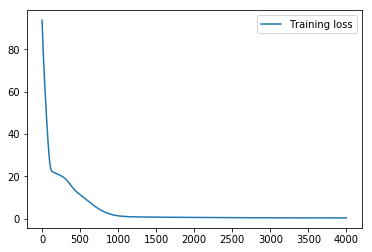

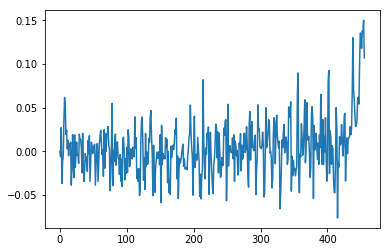

In [13]:
    # visualization
    index_plot = np.arange(test_year*12*4)
    year_index = np.arange(2013,2017,1)
    # repeat climatology as reference
    #climatology = np.tile(seansonal_cycle_SIC,len(year_ERAI))
    # create index
    print ("*******************  verification  **********************")
    fig00 = plt.figure()
    plt.plot(np.arange(sequence_len-test_year*12*4), np.sum(np.sum(pred_fake_sic[:-1,:,:],2),1), 'r',label="Prediction_fake")
    plt.plot(np.arange(sequence_len-test_year*12*4), np.sum(np.sum(sic_exp_norm[:-test_year*12*4,:,:],2),1), 'b',label="Data")
    plt.xlabel('time')
    plt.legend(loc=1)
    plt.show()
    print ("*******************  Predicted Ice Extent  **********************")
    # include text box in the figure
    #text_content = '$RMSE=%.3f$ ' % (error_pred)
    fig0 = plt.figure()
    plt.plot(index_plot, np.sum(np.sum(data_predict_sic,2),1), 'r',label="Prediction")
    plt.scatter(index_plot, np.sum(np.sum(data_predict_sic,2),1), color='r')
    plt.plot(index_plot, np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1), 'b',label="Data")
    plt.scatter(index_plot,np.sum(np.sum(sic_exp_norm[-test_year*12*4:,:,:],2),1),color='b')

    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    plt.xlabel('time')
    plt.xticks(np.arange(0,test_year*12*4,6*4),(['201401', '201407',  '201501', '201507', '201601', '201607']))
    plt.legend(loc=1)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    #ax = plt.gca()
    #ax.text(0.03,0.2,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred.png'),dpi=300)

    print ("*******************  Loss with time  **********************")
    fig1 = plt.figure()
    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()
    fig1.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_error.png'),dpi=300)
    
    print ("*******************  Prediction Ice Distribution  **********************")
    weak = 1
    fig2 = plt.figure()
    plt.vlines(index_plot[-test_year*12*4],0,1,colors='g',linestyle='dashed',linewidth=2)
    plt.plot(index_plot, data_predict[:,0], 'r',label="Prediction") #[:,0] is SIC
    plt.plot(index_plot, SIC_ERAI_sum_norm, 'b',label="Data")
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Training")
    plt.xlabel('time')
    plt.xticks(np.arange(12*4+1,len(index_plot)+1,60*4),year_index)
    plt.legend()
    plt.show()
    fig2.savefig(os.path.join(output_path,'SIC_{}_ERAI_LSTM_pred_full.png'.format(region_name)),dpi=300)
    
    print ("*******************  Other variables (Prediction with testing sets only) **********************")

In [ ]:
#     print ('*******************  run linear regression  *********************')
#     model = LinearReg()
#     # construct loss function and an optimizer.
#     criterion = torch.nn.MSELoss(size_average=False)
#     optimizer = torch.optim.SGD(model.parameters(),lr=0.01) # learning rate (lr)
#     #####################
#     # Train Loop
#     #####################
#     for epoch in range(num_epoch):
#         # predict y by fit x through linear regression
#         y_predict = model(SIV_var)
#         # compute and print loss
#         loss = criterion(y_predict,y_train)
        
#         # backpropagation and gradient descend (fix steps)
#         # Zero out gradient, else they will accumulate between epochs
#         optimizer.zero_grad()
    
#         # Backward pass
#         loss.backward()

#         # Update parameters
#         optimizer.step()        